## Exploration of LRP with binary MNIST

**Function        : Exploration of LRP with binary MNIST**<br>
**Author          : Team DIANNA**<br>
**Contributor     :**<br>
**First Built     : 2021.07.13**<br>
**Last Update     : 2021.07.27**<br>
**Library         : os, numpy, matplotlib, torch, captum**<br>
**Description     : In this notebook we test XAI method LRP using trained binary MNIST model.**<br>
**Return Values   : Heat maps**<br>
**Note**          : We use Captum library to perform LRP. This library works only with pytorch and it is not compitable with onnx.<br>

In [1]:
%matplotlib inline
import os
import time as tt
import numpy as np
# DL framework
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
#import torch.onnx
# XAI framework
from captum.attr import LRP
from captum.attr import visualization as viz
# for plotting
import matplotlib.pyplot as plt

### Path to the dataset and the model

In [2]:
# please specify data path
datapath = '/mnt/d/NLeSC/DIANNA/data/mnist/binary-MNIST'
# please specify model path
model_path = '/mnt/d/NLeSC/DIANNA/codebase/dianna/example_data/model_generation/MNIST'

### Load data (binary MNIST)

In [3]:
# load binary MNIST from local
# load data
fd = np.load(os.path.join(datapath, 'binary-mnist.npz'))
# training set
train_X = fd['X_train']
train_y = fd['y_train']
# testing set
test_X = fd['X_test']
test_y = fd['y_test']
fd.close()

# dimensions of data
print("dimensions of mnist:")
print("dimensions or training set", train_X.shape)
print("dimensions or training set label", train_y.shape)
print("dimensions or testing set", test_X.shape)
print("dimensions or testing set label", test_y.shape)
# statistics of training set
print("statistics of training set:")
print("Digits: 0 1")
print("labels: {}".format(np.unique(train_y)))
print("Class distribution: {}".format(np.bincount(train_y)))
print("Labels of training set", train_y[:20])

dimensions of mnist:
dimensions or training set (12665, 784)
dimensions or training set label (12665,)
dimensions or testing set (2115, 784)
dimensions or testing set label (2115,)
statistics of training set:
Digits: 0 1
labels: [0 1]
Class distribution: [5923 6742]
Labels of training set [0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1]


### Prepare data as torch tensor

In [4]:
# use pytorch data loader
test_X_torch = torch.from_numpy(test_X).type(torch.FloatTensor)
test_y_torch = torch.from_numpy(test_y).type(torch.LongTensor)
# reshape the input following the definition in pytorch (batch, channel, Height, Width)
test_X_torch = test_X_torch.view(-1,1,28,28)

### Load model (Pytorch model trained for binary MNIST)

In [5]:
# define the model first
class MnistNet(nn.Module):
    def __init__(self, kernels=[16, 32], dropout = 0.1, classes=2):
        '''
        Two layer CNN model with max pooling.
        '''
        super(MnistNet, self).__init__()
        self.kernels = kernels
        # 1st layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout()
        )
        # 2nd layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout()
        )
        self.fc1 = nn.Linear(7 * 7 * kernels[-1], kernels[-1]) # pixel 28 / maxpooling 2 * 2 = 7
        self.fc2 = nn.Linear(kernels[-1], classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# hyper-parameters
kernels = [16, 32]
dropout = 0.5
classes = 2
# create model
model = MnistNet(kernels, dropout, classes)
# load whole model state
checkpoint = torch.load(os.path.join(model_path, 'mnistnet_training_checkpoint.pt'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Predict the class of the input image <br>

In [6]:
# check the prediction
model.eval()

# overall test accuracy
correct = 0
for i in range(len(test_X_torch)):
    output = model(test_X_torch[i:i+1,:,:,:])
    predicted = torch.max(output,1)[1]
    correct += (predicted == test_y[i]).sum()

print("Test accuracy:{:.3f}% ".format(float(correct*100) / float(len(test_X_torch))))

# check one case
output = model(test_X_torch[:1,:,:,:])
predicted = torch.max(output,1)[1]
print("prediction", predicted)
print("ground truth", test_y[0])

Test accuracy:99.905% 
prediction tensor([1])
ground truth 1


### LRP-based attribution <br>
Compute attributions using LRP and visualize them on the image. <br>
Layer-wise relevance propagation is based on a backward propagation mechanism applied sequentially to all layers of the model. The model output score represents the initial relevance which is decomposed into values for each neuron of the underlying layers.<br>

/home/yangliu/miniconda3/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/yangliu/miniconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


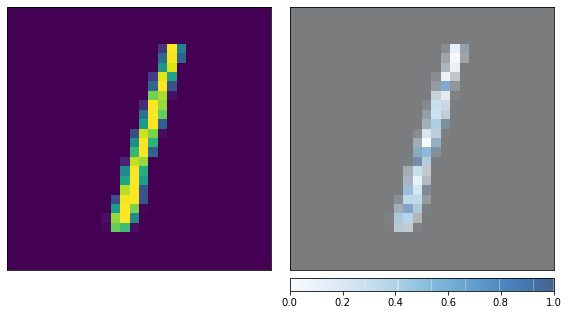

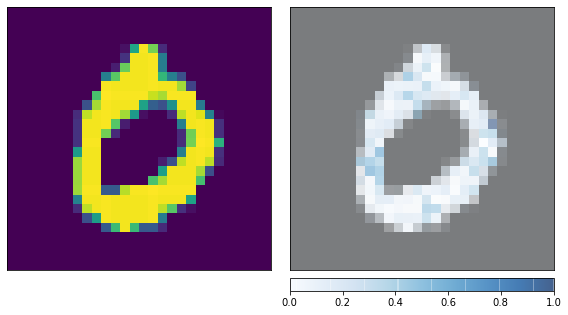

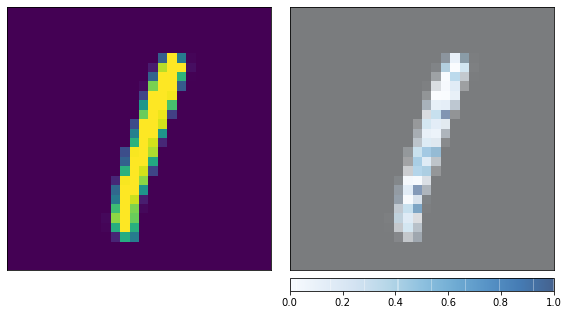

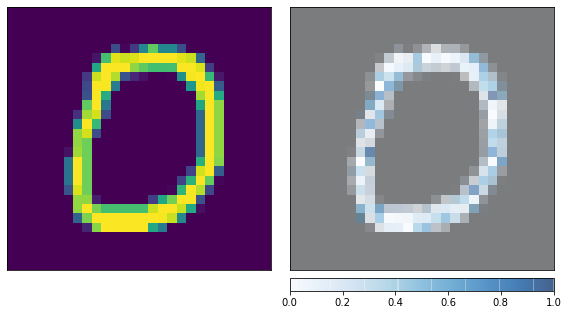

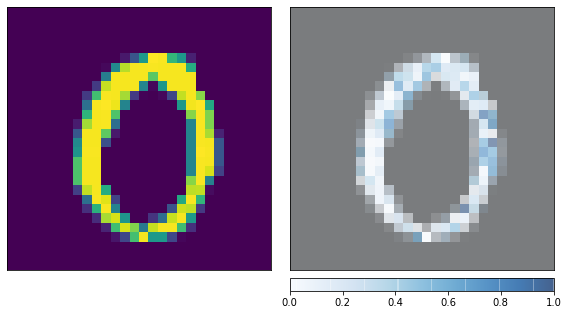

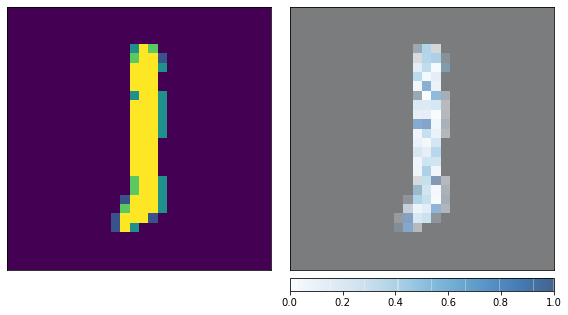

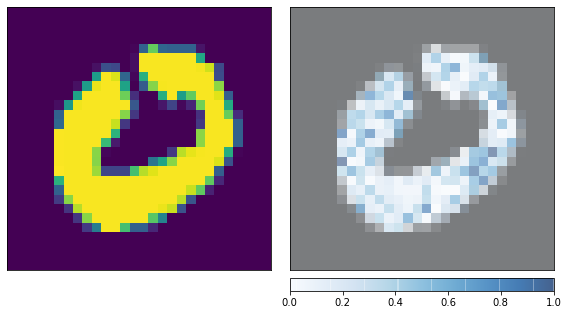

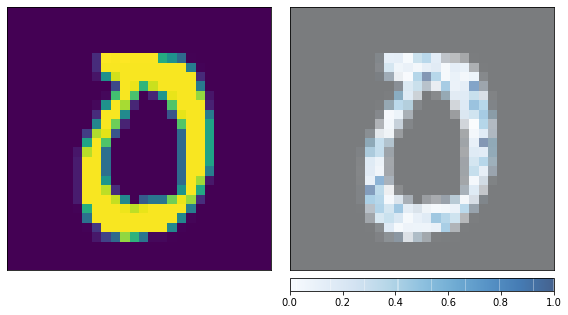

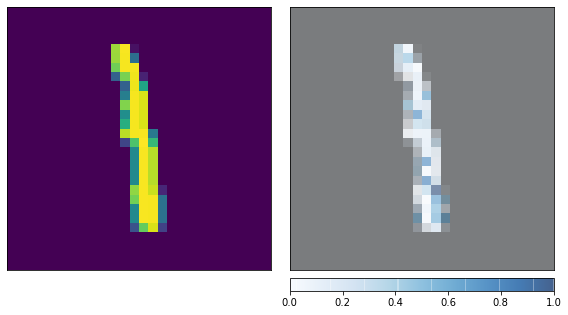

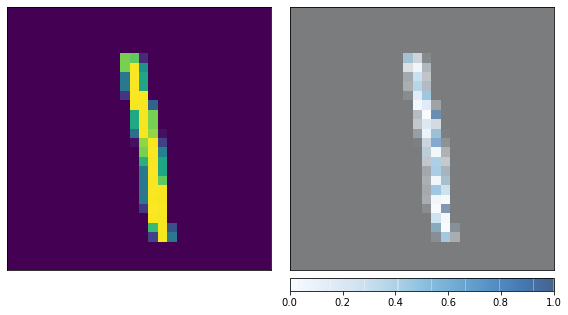

In [7]:
lrp = LRP(model)

case = 10
for i in range(case):
    # note that the model is so well trained and the output can sometimes be 0 
    # (which means the prediction is close to 1, given the output calculated as log_softmax)
    # This will cause an error for this implementation. To avoid this, we check the other class (`target=(1-test_y_torch[i])`),
    # which is equivalent since the results all indicate the relevance pixel for the prediction (two sides of one coin)
    attributions_lrp = lrp.attribute(test_X_torch[i:i+1,:,:,:], target=(1-test_y_torch[i]))
    # display attraibution map alongside with the predictand
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_lrp[0,:,:,:].cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(test_X_torch[i,:,:,:].cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "blended_heat_map"],
                                          ["all", "absolute_value"],
                                          show_colorbar=True)